In [ ]:
Так как я установил tensorflow второй версии, возникло много проблем с портированием. 
В инете подавляющее большинство примеров на tensorflow первой версии. Что-то получалось портировать, а что-то нет.
В добавок и другие проблемы, например время обучения моделей очень большое. 
После долгих поисков, многократных попыток, вот что получилось у меня.
Обучил модель U-Net сегментировать колоса пшениц. 
Успел только проверить: увеличение эпох сказывается положительно на сегментировании, также положительно сказывается 
применение функции активации elu.

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.measure import label, regionprops
from PIL import Image, ImageDraw
from ast import literal_eval
from tqdm.notebook import tqdm

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
assert IMG_WIDTH == IMG_HEIGHT

IMG_CHANNELS = 3
TRAIN_PATH = 'input/global-wheat-detection/train/'
TEST_PATH = 'input/global-wheat-detection/test/'
SC_FACTOR = int(1024 / IMG_WIDTH)

warnings.filterwarnings('ignore')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
PATH = "input/global-wheat-detection/"
train_folder = os.path.join(PATH, "train")
test_folder = os.path.join(PATH, "test")

train_csv_path = os.path.join(PATH, "train.csv")
df = pd.read_csv(train_csv_path)
sample_sub = pd.read_csv(PATH + "sample_submission.csv")

df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [3]:
# Get train and test IDs and paths
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

#### Convert multiple bounding boxes to masks

In [4]:
def make_polygon(coords):
    xm, ym, w, h = coords
    xm, ym, w, h = xm / SC_FACTOR, ym / SC_FACTOR, w / SC_FACTOR, h / SC_FACTOR   # scale values if image was downsized
    return [(xm, ym), (xm, ym + h), (xm + w, ym + h), (xm + w, ym)]

masks = dict() # dictionnary containing all masks

for img_id, gp in tqdm(df.groupby("image_id")):
    gp['polygons'] = gp['bbox'].apply(eval).apply(lambda x: make_polygon(x))

    img = Image.new('L', (IMG_WIDTH, IMG_HEIGHT), 0)
    for pol in gp['polygons'].values:
        ImageDraw.Draw(img).polygon(pol, outline=1, fill=1)

    mask = np.array(img, dtype=np.uint8)
    masks[img_id] = mask

#### Let's plot a quick example of the mask of the first image :

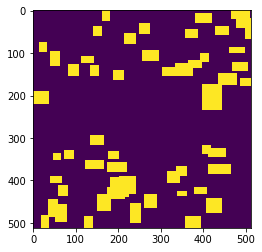

In [5]:
im = Image.fromarray(masks[list(masks.keys())[7]])
plt.imshow(im)

#### Let's load the dataset

In [6]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids[:]), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    id_clean = id_.split('.')[0]
    if id_clean in masks.keys():
        Y_train[n] = masks[id_clean][:, :, np.newaxis]
        

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = list()
print('Getting and resizing test images... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks... 



Getting and resizing test images... 



Done!


In [7]:
X_train.shape, Y_train.shape

((3422, 512, 512, 3), (3422, 512, 512, 1))

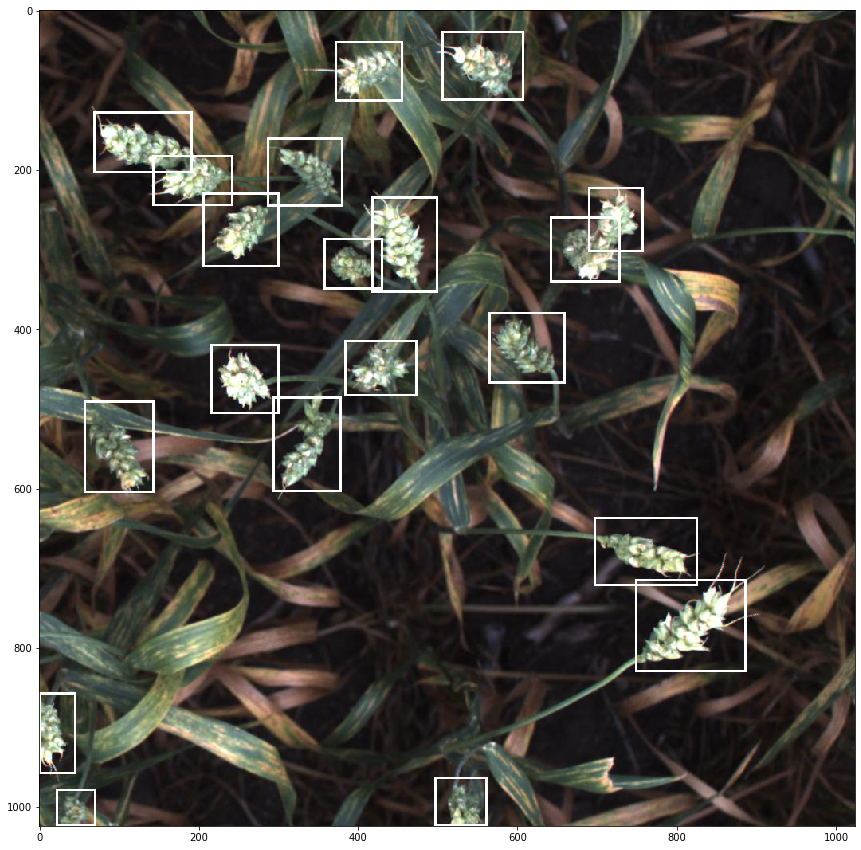

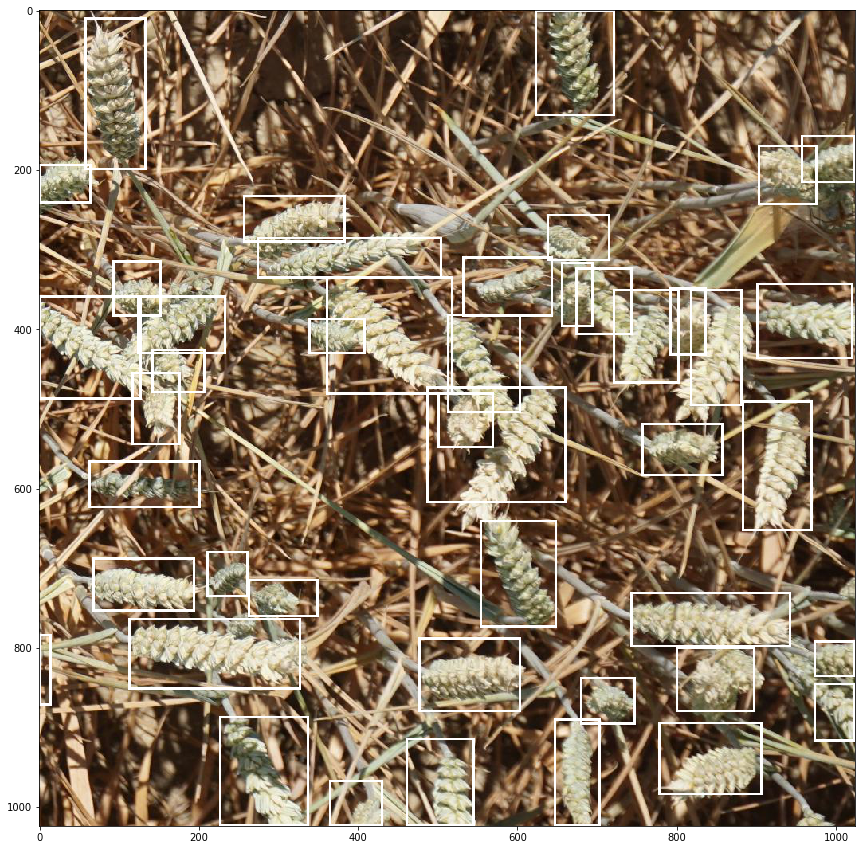

In [8]:
def show_images(images, num=2):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join(train_folder, image_id + ".jpg")
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in df[df['image_id'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], width=3)

        plt.figure(figsize = (15,15))
        plt.imshow(image)
        plt.show()


unique_images = df['image_id'].unique()
show_images(unique_images)

In [9]:
#Credits to : https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63044

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i * 0.05)  for i in range(5)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [10]:
# U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[competitionMetric2])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [18]:
# pip install Graphviz
# os.environ["PATH"] += os.pathsep + r"C:\Program Files (x86)\Graphviz2.38\bin"

In [20]:
from keras.utils import plot_model
# plot_model(model, show_shapes=True)

In [31]:
# Fit model
earlystop = EarlyStopping(patience=15, verbose=1)

hist = model.fit(X_train, 
                 Y_train,
                 validation_split=0.3,
                 batch_size=32, 
                 epochs=15, 
                 callbacks=[earlystop],
                )

Train on 2395 samples, validate on 1027 samples
Epoch 1/15
2395/2395 [==============================] - ETA: 31:00 - loss: 0.3550 - competitionMetric2: 0.356 - ETA: 29:20 - loss: 0.3468 - competitionMetric2: 0.415 - ETA: 28:43 - loss: 0.3504 - competitionMetric2: 0.400 - ETA: 28:13 - loss: 0.3683 - competitionMetric2: 0.354 - ETA: 27:43 - loss: 0.3735 - competitionMetric2: 0.326 - ETA: 27:17 - loss: 0.3681 - competitionMetric2: 0.325 - ETA: 26:51 - loss: 0.3671 - competitionMetric2: 0.328 - ETA: 26:24 - loss: 0.3666 - competitionMetric2: 0.316 - ETA: 26:01 - loss: 0.3629 - competitionMetric2: 0.303 - ETA: 25:35 - loss: 0.3620 - competitionMetric2: 0.295 - ETA: 25:11 - loss: 0.3623 - competitionMetric2: 0.297 - ETA: 24:47 - loss: 0.3612 - competitionMetric2: 0.301 - ETA: 24:23 - loss: 0.3603 - competitionMetric2: 0.308 - ETA: 23:59 - loss: 0.3606 - competitionMetric2: 0.310 - ETA: 23:35 - loss: 0.3594 - competitionMetric2: 0.311 - ETA: 23:11 - loss: 0.3596 - competitionMetric2: 0.314 - 

2395/2395 [==============================] - ETA: 34:32 - loss: 0.2888 - competitionMetric2: 0.393 - ETA: 30:54 - loss: 0.2877 - competitionMetric2: 0.484 - ETA: 33:46 - loss: 0.2917 - competitionMetric2: 0.508 - ETA: 32:11 - loss: 0.3044 - competitionMetric2: 0.489 - ETA: 30:47 - loss: 0.3029 - competitionMetric2: 0.482 - ETA: 29:40 - loss: 0.2991 - competitionMetric2: 0.466 - ETA: 28:47 - loss: 0.3037 - competitionMetric2: 0.468 - ETA: 28:01 - loss: 0.3057 - competitionMetric2: 0.471 - ETA: 27:20 - loss: 0.2992 - competitionMetric2: 0.491 - ETA: 26:55 - loss: 0.2948 - competitionMetric2: 0.497 - ETA: 26:19 - loss: 0.2982 - competitionMetric2: 0.494 - ETA: 25:45 - loss: 0.2980 - competitionMetric2: 0.510 - ETA: 25:12 - loss: 0.2969 - competitionMetric2: 0.523 - ETA: 24:41 - loss: 0.2970 - competitionMetric2: 0.521 - ETA: 24:12 - loss: 0.2975 - competitionMetric2: 0.522 - ETA: 23:43 - loss: 0.2989 - competitionMetric2: 0.519 - ETA: 24:34 - loss: 0.2976 - competitionMetric2: 0.516 - ETA

2395/2395 [==============================] - ETA: 1:29:20 - loss: 0.2599 - competitionMetric2: 0.718 - ETA: 58:04 - loss: 0.2649 - competitionMetric2: 0.6875  - ETA: 47:24 - loss: 0.2693 - competitionMetric2: 0.691 - ETA: 41:48 - loss: 0.2645 - competitionMetric2: 0.662 - ETA: 38:21 - loss: 0.2674 - competitionMetric2: 0.651 - ETA: 35:53 - loss: 0.2607 - competitionMetric2: 0.662 - ETA: 34:01 - loss: 0.2616 - competitionMetric2: 0.661 - ETA: 32:34 - loss: 0.2615 - competitionMetric2: 0.669 - ETA: 31:19 - loss: 0.2624 - competitionMetric2: 0.665 - ETA: 30:13 - loss: 0.2590 - competitionMetric2: 0.671 - ETA: 29:17 - loss: 0.2585 - competitionMetric2: 0.671 - ETA: 28:25 - loss: 0.2592 - competitionMetric2: 0.670 - ETA: 27:38 - loss: 0.2569 - competitionMetric2: 0.676 - ETA: 26:54 - loss: 0.2569 - competitionMetric2: 0.683 - ETA: 26:13 - loss: 0.2559 - competitionMetric2: 0.692 - ETA: 25:36 - loss: 0.2564 - competitionMetric2: 0.686 - ETA: 24:58 - loss: 0.2553 - competitionMetric2: 0.679 -

2395/2395 [==============================] - ETA: 1:25:39 - loss: 0.2503 - competitionMetric2: 0.668 - ETA: 56:33 - loss: 0.2312 - competitionMetric2: 0.6469  - ETA: 46:21 - loss: 0.2355 - competitionMetric2: 0.654 - ETA: 41:05 - loss: 0.2311 - competitionMetric2: 0.676 - ETA: 37:45 - loss: 0.2288 - competitionMetric2: 0.696 - ETA: 35:27 - loss: 0.2277 - competitionMetric2: 0.703 - ETA: 33:37 - loss: 0.2289 - competitionMetric2: 0.711 - ETA: 32:10 - loss: 0.2253 - competitionMetric2: 0.720 - ETA: 30:59 - loss: 0.2262 - competitionMetric2: 0.720 - ETA: 29:56 - loss: 0.2283 - competitionMetric2: 0.725 - ETA: 29:01 - loss: 0.2292 - competitionMetric2: 0.726 - ETA: 28:11 - loss: 0.2310 - competitionMetric2: 0.724 - ETA: 27:26 - loss: 0.2318 - competitionMetric2: 0.728 - ETA: 26:45 - loss: 0.2321 - competitionMetric2: 0.730 - ETA: 26:04 - loss: 0.2336 - competitionMetric2: 0.728 - ETA: 25:26 - loss: 0.2348 - competitionMetric2: 0.730 - ETA: 24:51 - loss: 0.2350 - competitionMetric2: 0.729 -

2395/2395 [==============================] - ETA: 1:06:35 - loss: 0.2143 - competitionMetric2: 0.725 - ETA: 46:50 - loss: 0.2195 - competitionMetric2: 0.7688  - ETA: 39:57 - loss: 0.2212 - competitionMetric2: 0.791 - ETA: 36:26 - loss: 0.2183 - competitionMetric2: 0.803 - ETA: 34:03 - loss: 0.2157 - competitionMetric2: 0.787 - ETA: 32:21 - loss: 0.2236 - competitionMetric2: 0.757 - ETA: 31:02 - loss: 0.2221 - competitionMetric2: 0.762 - ETA: 29:57 - loss: 0.2277 - competitionMetric2: 0.753 - ETA: 29:29 - loss: 0.2298 - competitionMetric2: 0.753 - ETA: 29:05 - loss: 0.2309 - competitionMetric2: 0.747 - ETA: 28:16 - loss: 0.2289 - competitionMetric2: 0.751 - ETA: 29:04 - loss: 0.2291 - competitionMetric2: 0.742 - ETA: 28:13 - loss: 0.2271 - competitionMetric2: 0.744 - ETA: 27:27 - loss: 0.2280 - competitionMetric2: 0.740 - ETA: 26:43 - loss: 0.2297 - competitionMetric2: 0.738 - ETA: 26:43 - loss: 0.2284 - competitionMetric2: 0.749 - ETA: 26:01 - loss: 0.2296 - competitionMetric2: 0.741 -

2395/2395 [==============================] - ETA: 1:19:37 - loss: 0.2141 - competitionMetric2: 0.800 - ETA: 53:21 - loss: 0.2053 - competitionMetric2: 0.8188  - ETA: 44:10 - loss: 0.2018 - competitionMetric2: 0.822 - ETA: 39:26 - loss: 0.2019 - competitionMetric2: 0.839 - ETA: 36:25 - loss: 0.2028 - competitionMetric2: 0.857 - ETA: 34:16 - loss: 0.2028 - competitionMetric2: 0.838 - ETA: 32:40 - loss: 0.2031 - competitionMetric2: 0.836 - ETA: 31:54 - loss: 0.2002 - competitionMetric2: 0.840 - ETA: 30:44 - loss: 0.2004 - competitionMetric2: 0.843 - ETA: 29:43 - loss: 0.2000 - competitionMetric2: 0.846 - ETA: 30:31 - loss: 0.1993 - competitionMetric2: 0.842 - ETA: 29:35 - loss: 0.1996 - competitionMetric2: 0.843 - ETA: 28:40 - loss: 0.1989 - competitionMetric2: 0.841 - ETA: 27:52 - loss: 0.1991 - competitionMetric2: 0.843 - ETA: 27:06 - loss: 0.1986 - competitionMetric2: 0.845 - ETA: 27:14 - loss: 0.1975 - competitionMetric2: 0.847 - ETA: 26:45 - loss: 0.1991 - competitionMetric2: 0.847 -

2395/2395 [==============================] - ETA: 1:38:53 - loss: 0.2016 - competitionMetric2: 0.862 - ETA: 1:12:44 - loss: 0.2009 - competitionMetric2: 0.850 - ETA: 57:03 - loss: 0.2026 - competitionMetric2: 0.8313  - ETA: 49:00 - loss: 0.2008 - competitionMetric2: 0.834 - ETA: 48:50 - loss: 0.1974 - competitionMetric2: 0.848 - ETA: 44:32 - loss: 0.1998 - competitionMetric2: 0.847 - ETA: 41:19 - loss: 0.1965 - competitionMetric2: 0.853 - ETA: 38:49 - loss: 0.1985 - competitionMetric2: 0.843 - ETA: 36:49 - loss: 0.1977 - competitionMetric2: 0.852 - ETA: 35:06 - loss: 0.1960 - competitionMetric2: 0.848 - ETA: 33:41 - loss: 0.1955 - competitionMetric2: 0.848 - ETA: 32:47 - loss: 0.1940 - competitionMetric2: 0.851 - ETA: 31:37 - loss: 0.1952 - competitionMetric2: 0.845 - ETA: 30:32 - loss: 0.1955 - competitionMetric2: 0.850 - ETA: 29:33 - loss: 0.1955 - competitionMetric2: 0.855 - ETA: 28:39 - loss: 0.1964 - competitionMetric2: 0.858 - ETA: 28:02 - loss: 0.1974 - competitionMetric2: 0.857

2395/2395 [==============================] - ETA: 1:09:25 - loss: 0.1920 - competitionMetric2: 0.818 - ETA: 48:16 - loss: 0.1785 - competitionMetric2: 0.8781  - ETA: 40:54 - loss: 0.1776 - competitionMetric2: 0.885 - ETA: 37:01 - loss: 0.1821 - competitionMetric2: 0.893 - ETA: 34:32 - loss: 0.1856 - competitionMetric2: 0.872 - ETA: 32:46 - loss: 0.1848 - competitionMetric2: 0.882 - ETA: 32:52 - loss: 0.1889 - competitionMetric2: 0.875 - ETA: 31:34 - loss: 0.1881 - competitionMetric2: 0.878 - ETA: 30:25 - loss: 0.1902 - competitionMetric2: 0.868 - ETA: 29:26 - loss: 0.1903 - competitionMetric2: 0.867 - ETA: 28:35 - loss: 0.1891 - competitionMetric2: 0.870 - ETA: 27:48 - loss: 0.1878 - competitionMetric2: 0.876 - ETA: 27:04 - loss: 0.1853 - competitionMetric2: 0.875 - ETA: 26:23 - loss: 0.1864 - competitionMetric2: 0.872 - ETA: 25:46 - loss: 0.1867 - competitionMetric2: 0.876 - ETA: 25:09 - loss: 0.1870 - competitionMetric2: 0.881 - ETA: 24:34 - loss: 0.1853 - competitionMetric2: 0.879 -

#### Prediction

As X_test is already formatted, we can directly make a prediction

In [32]:
THRESH = 0.7

preds = model.predict(X_test)[:, :, :, 0]
masked_preds = preds > THRESH

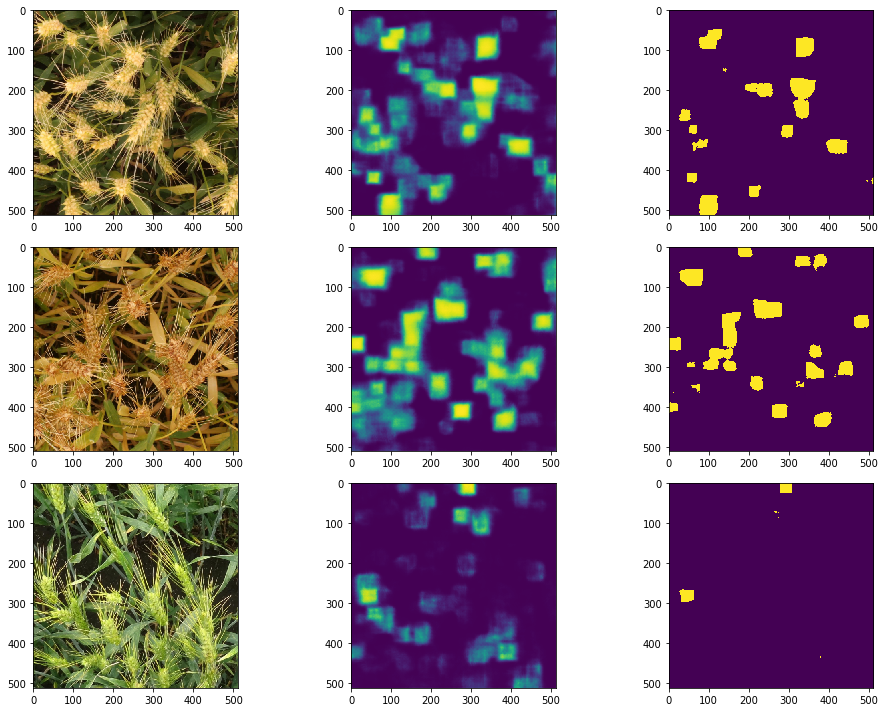

In [33]:
n_rows = 3

f, ax = plt.subplots(n_rows, 3, figsize=(14, 10))

for j, idx in enumerate([4,5,6]):
    for k, kind in enumerate(['original', 'pred', 'masked_pred']):
        if kind == 'original':
            img = X_test[idx]
        elif kind == 'pred':
            img = preds[idx]
        elif kind == 'masked_pred':
            masked_pred = preds[idx] > .75
            img = masked_pred
        ax[j, k].imshow(img)

plt.tight_layout()

In [34]:
def get_params_from_bbox(coords, scaling_factor=1):
    xmin, ymin = coords[1] * scaling_factor, coords[0] * scaling_factor
    w = (coords[3] - coords[1]) * scaling_factor
    h = (coords[2] - coords[0]) * scaling_factor
    
    return xmin, ymin, w, h

In [35]:
# Allows to extract bounding boxes from binary masks
bboxes = list()

for j in range(masked_preds.shape[0]):
    label_j = label(masked_preds[j, :, :]) 
    props = regionprops(label_j)
    bboxes.append(props)

In [36]:
output = dict()
for i in range(masked_preds.shape[0]):
    bboxes_processed = [get_params_from_bbox(bb.bbox, scaling_factor=SC_FACTOR) for bb in bboxes[i]]
    formated_boxes = ['1.0 ' + ' '.join(map(str, bb_m)) for bb_m in bboxes_processed]
    #if formated_boxes:
    #    formated_boxes = formated_boxes[0] 
    
    output[sample_sub["image_id"][i]] = " ".join(formated_boxes)
    #output[sample_sub["image_id"][i]] = formated_boxes

In [37]:
sample_sub["PredictionString"] = output.values()

In [38]:
sample_sub

,image_id,PredictionString
0,aac893a91,1.0 236 0 74 54 1.0 106 2 112 104 1.0 428 12 1...
1,51f1be19e,1.0 546 36 64 94 1.0 138 38 110 80 1.0 658 44 ...
2,f5a1f0358,1.0 552 32 92 94 1.0 640 40 2 2 1.0 662 48 124...
3,796707dd7,1.0 16 0 98 66 1.0 818 84 106 76 1.0 620 126 1...
4,51b3e36ab,1.0 148 92 118 106 1.0 630 134 98 104 1.0 254 ...
5,348a992bb,1.0 340 0 80 58 1.0 628 38 166 98 1.0 750 110 ...
6,cc3532ff6,1.0 548 0 70 54 1.0 522 136 44 52 1.0 562 158 ...
7,2fd875eaa,1.0 602 42 66 50 1.0 444 126 86 68 1.0 704 156...
8,cb8d261a3,1.0 390 14 66 86 1.0 778 26 88 94 1.0 416 236 ...
9,53f253011,1.0 30 16 30 36 1.0 14 18 18 36 1.0 666 106 78...


In [39]:
sample_sub.to_csv('input\submission.csv', index=False)